In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Libraries

In [ ]:
import keras
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import os
import pandas as pd

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, Input, Dense, Flatten,
                                     MaxPooling2D, GlobalAveragePooling2D,
                                     Dropout, BatchNormalization)

In [ ]:
img_height, img_width = 300,400
batch_size = 32
n_channels = 3
n_epochs = 10
image_dir = '/content/drive/MyDrive/Data (1)'

Load Data from Directory

In [ ]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
   validation_split=0.27
)

train_generator = datagen.flow_from_directory(image_dir,
                                              subset='training',
                                              target_size=(img_height, img_width),
                                              batch_size= batch_size,
                                              class_mode = 'categorical')

validation_generator = datagen.flow_from_directory(image_dir,
                                                    subset='validation',
                                                    target_size=(img_height, img_width),
                                                    batch_size= batch_size,
                                                    class_mode = 'categorical')

Found 153 images belonging to 3 classes.
Found 55 images belonging to 3 classes.


In [ ]:
basemodel = Xception(weights= 'imagenet', input_shape=(img_height, img_width , n_channels), include_top= False)
basemodel.trainable = False

input = Input(shape = (img_height, img_width , n_channels))
base = basemodel(input, training = False)

x = Conv2D(512, (3,3), padding = 'same', activation = 'relu')(base)
x = Dropout(rate = 0.7)(x)
x = Conv2D(256, (3,3), padding = 'same', activation = 'relu')(x)
x = Dropout(rate = 0.3)(x)
x = BatchNormalization()(x)
# x = Conv2D(128, (3,3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D(pool_size= (2,2))(x)
x = Conv2D(128, (3,3), padding = 'same', activation = 'relu')(x)
x = Dropout(rate = 0.3)(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation = 'relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(rate = 0.2)(x)
x = Dense(128, activation = 'relu')(x)
output = Dense(3, activation = 'softmax')(x)
model = Model(input, output)

lr = 0.0008
optimize = keras.optimizers.Adam(learning_rate=lr)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)

model.compile(optimizer=optimize, loss = loss, metrics= ['accuracy'])
checkpoint = keras.callbacks.ModelCheckpoint(
                            'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
                              save_best_only = True,
                              monitor = 'val_accuracy',
                              mode = 'max')
history = model.fit(train_generator, epochs=n_epochs, validation_data = validation_generator,
                    callbacks = [checkpoint])

Epoch 1/10
5/5 [==============================] - 34s 7s/step - loss: 0.8144 - accuracy: 0.5621 - val_loss: 1.0172 - val_accuracy: 0.6182
Epoch 2/10
5/5 [==============================] - 3s 643ms/step - loss: 0.5459 - accuracy: 0.7647 - val_loss: 3.8528 - val_accuracy: 0.5818
Epoch 3/10
5/5 [==============================] - 3s 636ms/step - loss: 0.3943 - accuracy: 0.8431 - val_loss: 0.9124 - val_accuracy: 0.8000
Epoch 4/10
5/5 [==============================] - 2s 478ms/step - loss: 0.3145 - accuracy: 0.8497 - val_loss: 1.0939 - val_accuracy: 0.7636
Epoch 5/10
5/5 [==============================] - 2s 475ms/step - loss: 0.1828 - accuracy: 0.9412 - val_loss: 1.3977 - val_accuracy: 0.6909
Epoch 6/10
5/5 [==============================] - 2s 529ms/step - loss: 0.2630 - accuracy: 0.9150 - val_loss: 1.2249 - val_accuracy: 0.6909
Epoch 7/10
5/5 [==============================] - 3s 502ms/step - loss: 0.1098 - accuracy: 0.9608 - val_loss: 2.4764 - val_accuracy: 0.6545
Epoch 8/10
5/5 [======

Visualize Model Result

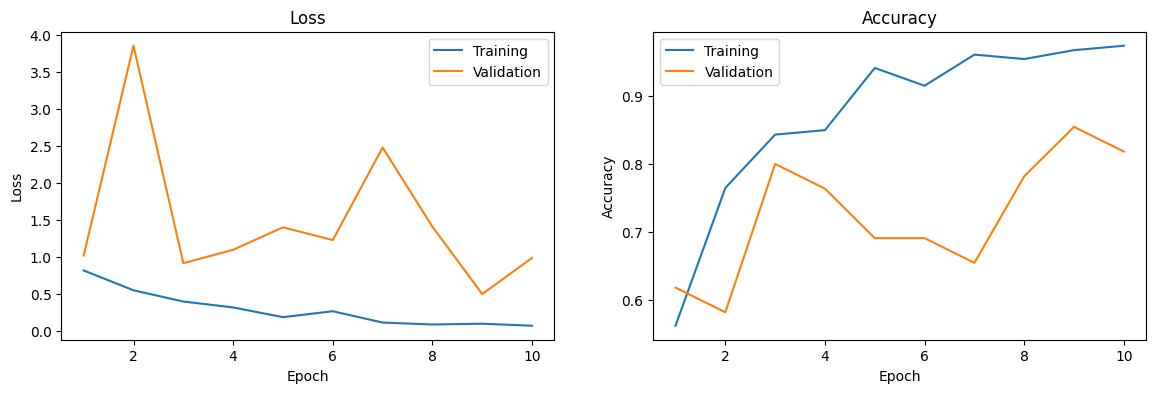

In [ ]:
results = history.history
n_epochs = len(results['loss'])

plt.figure(figsize=[14,4])

plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.plot(range(1, n_epochs+1), results['loss'], label='Training')
plt.plot(range(1, n_epochs+1), results['val_loss'], label='Validation')
plt.legend()


plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.plot(range(1, n_epochs+1), results['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), results['val_accuracy'], label='Validation')

plt.legend()
plt.show()

Model Evaluation

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = load_model('/content/xception_v1_08_0.792.h5')
test_loss, test_acc = model.evaluate(validation_generator, verbose=2)
print(f'Test accuracy: {test_acc*100:.2f}%')

2/2 - 2s - loss: 1.6165 - accuracy: 0.8000 - 2s/epoch - 793ms/step
Test accuracy: 80.00%


In [ ]:
# # Calculate accuracy
# accuracy = accuracy_score(true_labels, predicted_labels)
# print(f'Accuracy: {accuracy:.2f}')

# # Generate a classification report
# class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
# print('Classification Report:')
# print(class_report)

# # Generate a confusion matrix
# conf_matrix = confusion_matrix(true_labels, predicted_labels)
# print('Confusion Matrix:')
# print(conf_matrix)

2/2 [==============================] - 1s 329ms/step


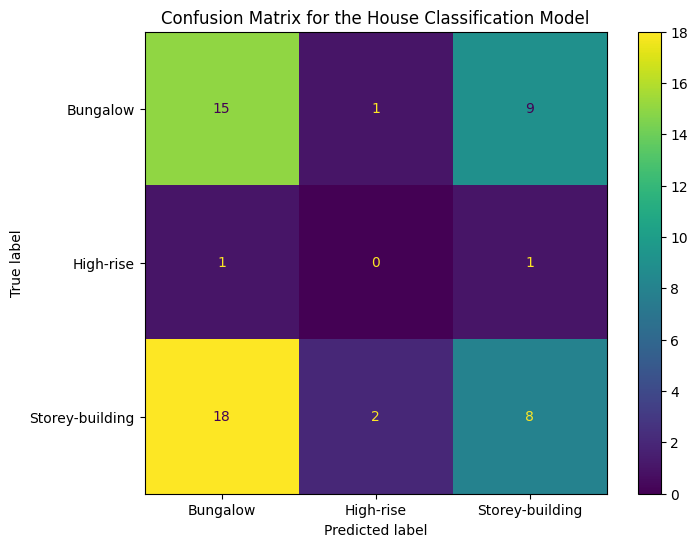

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

prediction = model.predict(validation_generator)
true_labels = validation_generator.classes
predicted_labels = np.argmax(prediction, axis = 1)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

display = ConfusionMatrixDisplay(conf_matrix, display_labels=list(validation_generator.class_indices.keys()))
ax.set(title='Confusion Matrix for the House Classification Model')

display.plot(ax=ax);

In [ ]:
from sklearn.metrics import classification_report

target_names = ['Bungalow', 'High-rise', 'Storey-building']
print(classification_report(true_labels, predicted_labels, target_names=target_names))

                 precision    recall  f1-score   support

       Bungalow       0.44      0.60      0.51        25
      High-rise       0.00      0.00      0.00         2
Storey-building       0.44      0.29      0.35        28

       accuracy                           0.42        55
      macro avg       0.30      0.30      0.29        55
   weighted avg       0.43      0.42      0.41        55

